# WHAT ARE WE YELLING ABOUT?

# Import Data

In [358]:
import community
import operator
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import EDA as eda
import json

sns.set(color_codes = True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [164]:
mega_df = eda.import_files()

In [132]:
mega_df.describe()

,id,likes,replies,retweets
count,4.193430e+05,419343.000000,419343.000000,419343.000000
mean,9.393097e+17,6.223788,0.206325,4.391949
std,1.750021e+15,415.162837,9.443255,304.453924
min,9.352972e+17,0.000000,0.000000,0.000000
25%,9.381515e+17,0.000000,0.000000,0.000000
50%,9.399272e+17,0.000000,0.000000,0.000000
75%,9.409810e+17,1.000000,0.000000,0.000000
max,9.414578e+17,216270.000000,3694.000000,165604.000000


# Data Cleaning

In [198]:
# This creates new columns for hashtags (other than #netneutrality), links, and mentions in the tweet data.
# It also creates a field for text without links since the same tweets with slightly different URLs keep
# coming up.

mega_df["other_hashtags"] = mega_df["text"].apply(eda.get_hashtags)
mega_df["links"] = mega_df["text"].apply(eda.get_links)
mega_df["@s"] = mega_df["text"].apply(eda.get_mentions)
mega_df['cleaned_text'] = mega_df['text'].apply(eda.clean_text)

In [196]:
d = {'text': ['oh wow @tyler sucks', '@!$ is that', 'hey@234tjeld fuk', '@', "suck @fcc's dick"]}
test_df = pd.DataFrame(data=d)
test_df

,text
0,oh wow @tyler sucks
1,@!$ is that
2,hey@234tjeld fuk
3,@
4,suck @fcc's dick


In [197]:
test_df["@s"] = test_df["text"].apply(eda.get_mentions)
test_df

,text,@s
0,oh wow @tyler sucks,[@tyler]
1,@!$ is that,[]
2,hey@234tjeld fuk,[]
3,@,[]
4,suck @fcc's dick,[]


## Identifying guided information campaigns

In [ ]:
# Create Counter that will tally up the number of times text appears in tweets

tweet_text_dict = eda.tweet_text_dict_fn(mega_df)

In [ ]:
campaign_tweet_set = eda.create_campaign_tweet_set(tweet_text_dict)
original_tweet_set = eda.create_original_tweet_set(tweet_text_dict)

In [ ]:
def info_campaign(text):
    if text in campaign_tweet_set:
        return 1
    else:
        return 0

In [ ]:
def original_tweet(text):
    if text in original_tweet_set:
        return 1
    else:
        return 0

In [ ]:
# Create new columns using above functions

mega_df['info_campaign'] = mega_df['cleaned_text'].apply(info_campaign)
mega_df['original_tweet'] = mega_df['cleaned_text'].apply(original_tweet)

## Get to work seeing if there are any tweets in here that appear to be pro-repeal of net neutrality

In [ ]:
# Function to be used in apply - labels tweets that appear to be pro-repeal of net neutrality

mega_df['pro_repeal'] = mega_df['other_hashtags'].apply(eda.negative_tweet_grab)

In [ ]:
# Create array of usernames that were classified as 'pro-repeal'

pro_repeal_users = mega_df['user'][mega_df['pro_repeal'] == 1]
pro_repeal_users_unique = mega_df['user'][mega_df['pro_repeal'] == 1].unique()

## Ok, now let's split the data into 3 categories:
### * Guided information campaign tweets
### * Original tweets (only showed up one time)
### * Tweets that appear to be pro-repeal of net neutrality that still used #netneutrality 

In [ ]:
campaign_tweets_df = mega_df[(mega_df['info_campaign'] == 1)]
original_tweets_df = mega_df[(mega_df['original_tweet'] == 1) & (mega_df['pro_repeal'] == 0)]

# All of the tweets in this category are determined to be original - there were not any that were classified as \
# pro-repeal and part of an information campaign. The total number of pro-repeal tweets is low.
repeal_tweets_df = mega_df[(mega_df['pro_repeal'] == 1) & (mega_df['original_tweet'] == 1)]

In [ ]:
original_total = mega_df['fullname'].count()
new_total = (campaign_tweets_df['fullname'].count()) + (original_tweets_df['fullname'].count()) + \
(repeal_tweets_df['fullname'].count())

# This removed a total of 7.72% of my data since I was not confident in how to classify it as an information campaign
# or original tweet.
print(((original_total - new_total) / original_total) * 100)

## Some EDA

In [ ]:
# For my final dataset, what was the breakdown between these three categories?
total_tweets = campaign_tweets_df['fullname'].count() + repeal_tweets_df['fullname'].count() + original_tweets_df['fullname'].count()
percentages = [str(campaign_tweets_df['fullname'].count()/total_tweets), str(repeal_tweets_df['fullname'].count()/total_tweets), \
         str(original_tweets_df['fullname'].count()/total_tweets)]

plt.axes(aspect='equal')
plt.pie([campaign_tweets_df['fullname'].count(), repeal_tweets_df['fullname'].count(), \
         original_tweets_df['fullname'].count()], explode=[.1, .1 , .1], \
        labels=['Campaign Tweets', 'Repeal Tweets', 'Original Tweets'], autopct='%3.2f%%')
plt.title('Percent of Tweets in Each Category')
plt.show()

In [ ]:
mega_df['retweets'].describe()

In [ ]:
# Count of retweets with outliers removed

retweets_outliers_rmv = eda.remove_outliers(mega_df, 'retweets')

In [ ]:
ticks = np.linspace(0,1, 11)

plt.hist(retweets_outliers_rmv, alpha=.5, bins = retweets_outliers_rmv.max(), normed=True)
plt.xlabel('Number of Retweets')
plt.ylabel('Percent of Total')
plt.yticks(ticks)
plt.title('Less than 20% of all Tweets were retweeted')
plt.xlim(0,10)
plt.show()

In [ ]:
# Count of likes with outliers removed

likes_outliers_rmv = eda.remove_outliers(mega_df, 'likes')

In [ ]:
ticks = np.linspace(0,1, 11)

plt.hist(likes_outliers_rmv, alpha=.5, bins = likes_outliers_rmv.max(), normed=True)
plt.xlabel('Number of Likes')
plt.ylabel('Percent of Total')
plt.yticks(ticks)
plt.title('Less than 30% of all Tweets were liked')
plt.xlim(0,10)
plt.show()

In [ ]:
# Count of replies with outliers removed

replies_outliers_rmv = eda.remove_outliers(mega_df, 'replies')

In [ ]:
ticks = np.linspace(0,1, 11)

plt.hist(replies_outliers_rmv, bins = replies_outliers_rmv.max(), alpha=.5, normed=True)
plt.xlabel('Number of Replies')
plt.ylabel('Percent of Total')
plt.yticks(ticks)
plt.title('Less than 10% of all Tweets had replies')
plt.xlim(0,10)
plt.show()

## Time to compare the different categories

In [ ]:
# Original tweets

orig_retweets_outliers_rmv = eda.remove_outliers(original_tweets_df, 'retweets')

orig_likes_outliers_rmv = eda.remove_outliers(original_tweets_df, 'likes')

orig_replies_outliers_rmv = eda.remove_outliers(original_tweets_df, 'replies')

In [ ]:
# Campaign tweets

campaign_retweets_outliers_rmv = eda.remove_outliers(campaign_tweets_df, 'retweets')

campaign_likes_outliers_rmv = eda.remove_outliers(campaign_tweets_df, 'likes')

campaign_replies_outliers_rmv = eda.remove_outliers(campaign_tweets_df, 'replies')

In [ ]:
ticks = np.linspace(0,1, 11)
bins_x = orig_replies_outliers_rmv.max()
bins_y = campaign_replies_outliers_rmv.max()

x = orig_replies_outliers_rmv
y = campaign_replies_outliers_rmv

plt.hist(x, alpha=0.5, bins=bins_x, label='Replies to Original Tweets', normed=1)
plt.hist(y, alpha=0.5, bins=bins_y, label='Replies to Campaign Tweets', normed=1)
plt.yticks(ticks)
plt.xlim(0, 15)
plt.legend(loc='upper right')
plt.title('Very Few Campaign Tweets Get Replies')
plt.show()

I hypothesize that people can tell what is real and what is a campaign and they are much more likely to engage in organic conversations by replying.
# Change y axis to log scale

In [ ]:
original_replies = (original_tweets_df[original_tweets_df['replies'] != 0]['fullname'].count() / len(original_tweets_df['replies'])) * 100
campaign_replies = (campaign_tweets_df[campaign_tweets_df['replies'] != 0]['fullname'].count() / len(campaign_tweets_df['replies'])) * 100

print('Of all original tweets in the data, {:0.2f}% had a reply.'.format(original_replies))
print('Of all campaign tweets in the data, {:0.2f}% had a reply.'.format(campaign_replies))

In [ ]:
ticks = np.linspace(0,1, 11)
bins_x = orig_retweets_outliers_rmv.max()
bins_y = campaign_retweets_outliers_rmv.max()
x = orig_retweets_outliers_rmv
y = campaign_retweets_outliers_rmv

plt.hist(x, alpha=0.5, bins=bins_x, label='Retweets of Original Tweets', normed=1)
plt.hist(y, alpha=0.5, bins=bins_y, label='Retweets of Campaign Tweets', normed=1)
plt.yticks(ticks)
plt.xlim(0, 15)
plt.legend(loc='upper right')
plt.title('About A Quarter of Original Tweets Were Retweeted')
plt.show()

In [ ]:
original_retweets = (original_tweets_df[original_tweets_df['retweets'] != 0]['fullname'].count() / len(original_tweets_df['retweets'])) * 100
campaign_retweets = (campaign_tweets_df[campaign_tweets_df['retweets'] != 0]['fullname'].count() / len(campaign_tweets_df['retweets'])) * 100

print('Of all original tweets in the data, {:0.2f}% were retweeted.'.format(original_retweets))
print('Of all campaign tweets in the data, {:0.2f}% were retweeted.'.format(campaign_retweets))

In [ ]:
ticks = np.linspace(0,1, 11)
bins_x = orig_likes_outliers_rmv.max()
bins_y = campaign_likes_outliers_rmv.max()
x = orig_likes_outliers_rmv
y = campaign_likes_outliers_rmv

plt.hist(x, alpha=0.5, bins=bins_x, label='Likes of Original Tweets', normed=1)
plt.hist(y, alpha=0.5, bins=bins_y, label='Likes of Campaign Tweets', normed=1)
plt.yticks(ticks)
plt.xlim(0, 15)
plt.legend(loc='upper right')
plt.title('')
plt.show()

In [ ]:
original_likes = (original_tweets_df[original_tweets_df['likes'] != 0]['fullname'].count() / len(original_tweets_df['likes'])) * 100
campaign_likes = (campaign_tweets_df[campaign_tweets_df['likes'] != 0]['fullname'].count() / len(campaign_tweets_df['likes'])) * 100

print('Of all original tweets in the data, {:0.2f}% got likes.'.format(original_likes))
print('Of all campaign tweets in the data, {:0.2f}% got likes.'.format(campaign_likes))

## Start doing some NLP

In [ ]:
import spacy

nlp = spacy.load('en_core_web_md')

In [ ]:
def get_adj_lemmas(dataframe):
    lemma = []
    for doc in nlp.pipe(dataframe['cleaned_text'].astype('unicode').values, batch_size=50,
                            n_threads=3):
        if doc.is_parsed:
            lemma.append([n.lemma_ for n in doc if (n.pos_ == 'ADJ') & (n.lemma_ != '-PRON-')])
        else:
            # We want to make sure that the lists of parsed results have the
            # same number of entries of the original Dataframe, so add some blanks in case the parse fails
            lemma.append(None)

    dataframe['adj_lemmas'] = lemma
    return dataframe

In [ ]:
mega_df_1 = mega_df[:50000]
mega_df_2 = mega_df[50000:100000]
mega_df_3 = mega_df[100000:150000]
mega_df_4 = mega_df[150000:200000]
mega_df_5 = mega_df[200000:250000]
mega_df_6 = mega_df[250000:300000]
mega_df_7 = mega_df[300000:350000]
mega_df_8 = mega_df[350000:400000]
mega_df_9 = mega_df[400000:]

slice_list = [mega_df_1, mega_df_2, mega_df_3, mega_df_4, mega_df_5, mega_df_6, mega_df_7, mega_df_8, mega_df_9]

In [ ]:
# mega_df_1 = get_adj_lemmas(mega_df_1)
# mega_df_2 = get_adj_lemmas(mega_df_2)
# mega_df_3 = get_adj_lemmas(mega_df_3)
# mega_df_4 = get_adj_lemmas(mega_df_4)
# mega_df_5 = get_adj_lemmas(mega_df_5)
# mega_df_6 = get_adj_lemmas(mega_df_6)
# mega_df_7 = get_adj_lemmas(mega_df_7)
# mega_df_8 = get_adj_lemmas(mega_df_8)
# mega_df_9 = get_adj_lemmas(mega_df_9)

# mega_df_final = pd.concat([mega_df_1, mega_df_2, mega_df_3, mega_df_4, mega_df_5, mega_df_6, mega_df_7, mega_df_8, \
#                           mega_df_9], ignore_index=True)

In [207]:
# mega_df_final.to_json('./mega_df_final.json')

In [362]:
mega_df_final = pd.read_json('mega_df_final.json')
mega_df_final = mega_df_final.sort_index(axis=0)

## For each day recorded, what percent of tweets were original vs campaign?

In [363]:
mega_df_by_date = mega_df_final.set_index("timestamp")
mega_df_by_date = mega_df_by_date.resample("D").sum()

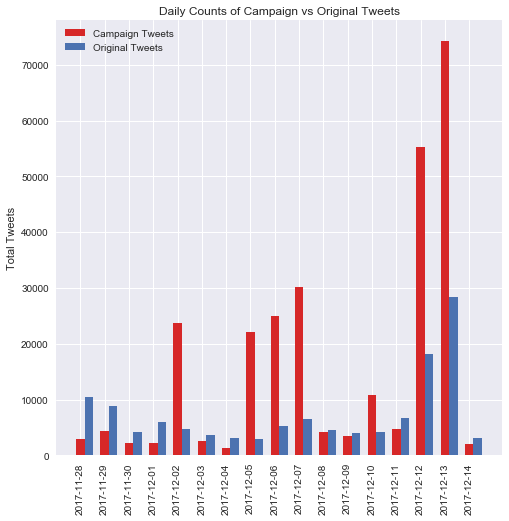

In [364]:
N = len(mega_df_by_date.index)
campaigns = mega_df_by_date['info_campaign']
originals = mega_df_by_date['original_tweet']
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

plt.subplots(figsize=(8,8))

p1 = plt.bar(ind, campaigns, width, color='#d62728')
p2 = plt.bar(ind + width, originals, width)

plt.ylabel('Total Tweets')
plt.title('Daily Counts of Campaign vs Original Tweets')
plt.xticks(ind, (mega_df_by_date.index.date), rotation=90)
# plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Campaign Tweets', 'Original Tweets'))

plt.show()

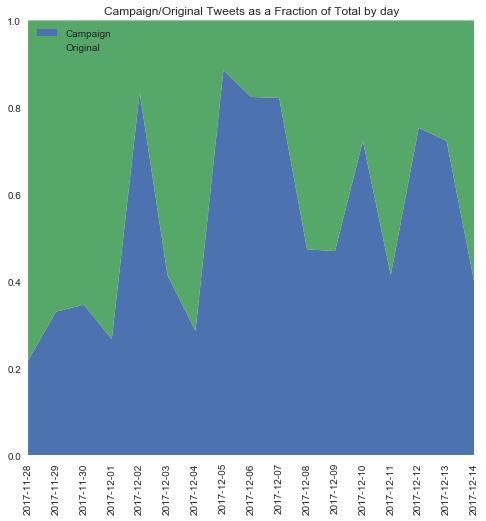

In [365]:
# Make data
data = pd.DataFrame({'Campaign Tweets':mega_df_by_date['info_campaign'], 'Original Tweets':mega_df_by_date['original_tweet']})
 
# We need to transform the data from raw data to percentage (fraction)
data_perc = data.divide(data.sum(axis=1), axis=0)

N = len(mega_df_by_date.index)
ind = np.arange(N)    # the x locations for the groups

# Make the plot
plt.subplots(figsize=(8,8))

plt.stackplot(ind, data_perc['Campaign Tweets'],  data_perc['Original Tweets'], labels=['Campaign','Original'], cmap='Pastel1')
plt.legend(loc='upper left')
plt.margins(0,0)
plt.xticks(ind, (mega_df_by_date.index.date), rotation=90)

plt.title('Campaign/Original Tweets as a Fraction of Total by day')
plt.show()


## Look at some adjectives

In [366]:
update_campaign_tweets_df = mega_df_final[mega_df_final['info_campaign'] == 1].drop_duplicates(subset='text')
update_original_tweets_df = mega_df_final[mega_df_final['original_tweet'] == 1]

In [377]:
from collections import Counter

original_adj_counter = Counter()
ignore_list = ['net', 'that', 'more', 'many', 'able', 'much', 'which', '“']

for adjs in update_original_tweets_df['adj_lemmas']:
    if (len(adjs) != 0):
        for adj in adjs:
            if adj not in ignore_list:
                original_adj_counter[adj] += 1

In [383]:
campaign_adj_counter = Counter()
ignore_list = ['net', 'that', 'more', 'many', 'able', 'much', 'which', 'fccs', 'monthsnapchat', 'powerfulinternetproviderslike', 'thiscontact']

for adjs in update_campaign_tweets_df['adj_lemmas']:
    if (len(adj) != 0):
        for adj in adjs:
            if adj not in ignore_list:
                campaign_adj_counter[adj] += 1

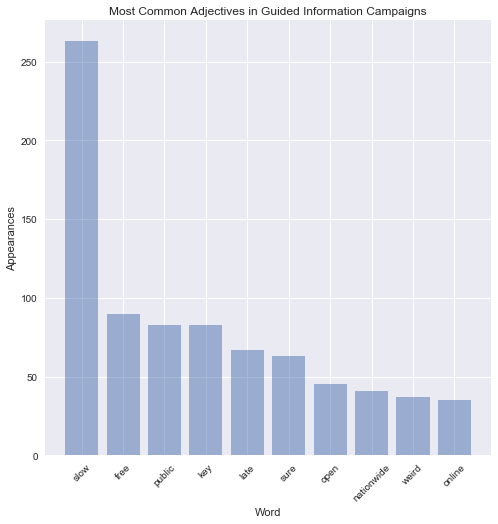

In [385]:
counts = dict(campaign_adj_counter.most_common(10))

labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]

# rearrange your data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

bar_width = 0.35

plt.subplots(figsize=(8,8))
plt.bar(indexes, values, alpha=.5)
plt.xticks(rotation=45)

# add labels
plt.xticks(indexes, labels)
plt.title('Most Common Adjectives in Guided Information Campaigns')
plt.ylabel('Appearances')
plt.xlabel('Word')
plt.show()

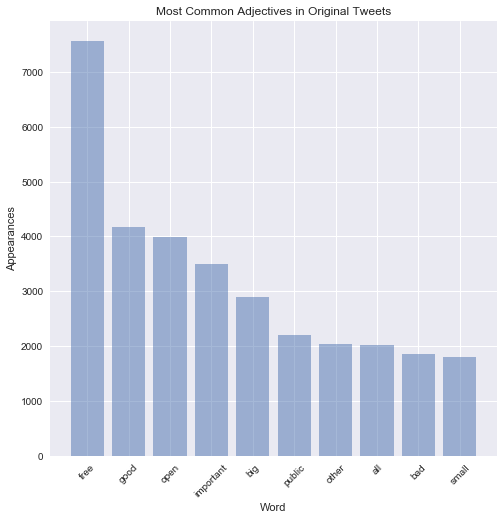

In [378]:
counts = dict(original_adj_counter.most_common(10))

labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]

# rearrange your data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

bar_width = 0.35

plt.subplots(figsize=(8,8))
plt.bar(indexes, values, alpha=.5)
plt.xticks(rotation=45)

# add labels
plt.xticks(indexes, labels, rotation=45)
plt.title('Most Common Adjectives in Original Tweets')
plt.ylabel('Appearances')
plt.xlabel('Word')
plt.show()

## Getting prepped to make a force-directed graph of @s
#### First, get a set of all @s done
#### Find every n=2 permutation of those that show up in tweets done
#### Remove dupes done
#### Get a count done
#### Get them formatted like the d3 graph will need

In [349]:
# Create a list of every 2-item combo of mentions found in tweets in the data.
flat_list = eda.combos_of_ats(mega_df_final)

# Arrange these into an array where the two mentions are arranged in alphabetical order.
alpha_array = eda.alpha_tuples(flat_list)

# Put this into a dataframe where the first item in every pair is in column 'source' and the second item is in column
# 'target'. Create a column 'count' that has a count of every time each pair showed up in the data.
grouped_source_target_df = eda.create_grouped_source_target(alpha_array)

In [350]:
# Restrict this to only pairs that showed up 10 times or more. The graph won't be interpretable otherwise, and this is
# a good threshold for determining whether or not accounts were mentioned together frequenlty enough to matter.
grouped_source_target_df = grouped_source_target_df[grouped_source_target_df['count'] > 9]

In [351]:
# Create an index of all the unique mentions in the data.
unique_ats = pd.Index(grouped_source_target_df['source']
                      .append(grouped_source_target_df['target'])
                      .reset_index(drop=True).unique())

In [352]:
# Create a list of every edge - a time that two accounts were mentioned in the same tweet.
links_list = eda.create_links_list(grouped_source_target_df, unique_ats)

# Create a list of every node
nodes_list = eda.create_nodes_list(unique_ats)

In [353]:
# Create this as a NetworkX graph object so I can do some community detection
G = nx.Graph()

# Add nodes to the graph
for node in nodes_list:
    G.add_node(node['index'], name=node['name'])

# Add links to the graph
for link in links_list:
    G.add_edge(link['source'], link['target'], weight=link['value'])

In [354]:
# Create optimized communities using Louvain modularity
communities = community.best_partition(G, partition=None, weight='weight', resolution=1.0, randomize=False)

In [355]:
# Add community numbers to the nodes
for idx, group in enumerate(communities.values()):
    nodes_list[idx]['group'] = group

In [356]:
json_prep = {"nodes":nodes_list, "links":links_list}
json_dump = json.dumps(json_prep, indent=1, sort_keys=True)

filename_out = 'nodes_edges.json'
json_out = open(filename_out,'w')
json_out.write(json_dump)
json_out.close()

In [321]:
bc_dict = nx.betweenness_centrality(G, weight='weight')
sorted_bc_tups = sorted(bc_dict.items(), key=operator.itemgetter(1), reverse=True)

### Remove highest betweened node and redo the graph to see if other communities come up

In [322]:
# Create a list of every 2-item combo of mentions found in tweets in the data that DO NOT include the node with
# highest betweenness centrality ('@ajitpaifcc').

flat_list_one_removed = []

for item in flat_list:
    if nodes_list[sorted_bc_tups[0][0]]['name'] not in item:
        flat_list_one_removed.append(item)

In [323]:
# Arrange these into an array where the two mentions are arranged in alphabetical order.
alpha_array_one_removed = eda.alpha_tuples(flat_list_one_removed)

# Put this into a dataframe where the first item in every pair is in column 'source' and the second item is in column
# 'target'. Create a column 'count' that has a count of every time each pair showed up in the data.
grouped_source_target_df_one_removed = eda.create_grouped_source_target(alpha_array_one_removed)

In [324]:
grouped_source_target_df_one_removed = grouped_source_target_df_one_removed[grouped_source_target_df_one_removed['count'] > 8]

In [325]:
# Create an index of all the unique mentions in the data.
unique_ats_one_removed = pd.Index(grouped_source_target_df_one_removed['source']
                      .append(grouped_source_target_df_one_removed['target'])
                      .reset_index(drop=True).unique())

In [326]:
# Create a list of every edge - a time that two accounts were mentioned in the same tweet.
links_list_one_removed = eda.create_links_list(grouped_source_target_df_one_removed, unique_ats_one_removed)

# Create a list of every node
nodes_list_one_removed = eda.create_nodes_list(unique_ats_one_removed)

In [327]:
G_one_removed = nx.Graph()

In [328]:
for node in nodes_list_one_removed:
    G_one_removed.add_node(node['index'], name=node['name'])

In [329]:
for link in links_list_one_removed:
    G_one_removed.add_edge(link['source'], link['target'], weight=link['value'])

In [330]:
communities_one_removed = community.best_partition(G_one_removed, partition=None, weight='weight', resolution=1.0, randomize=False)

In [331]:
for idx, group in enumerate(communities_one_removed.values()):
    nodes_list_one_removed[idx]['group'] = group

In [332]:
json_prep_removed = {"nodes":nodes_list_one_removed, "links":links_list_one_removed}
json_dump_removed = json.dumps(json_prep_removed, indent=1, sort_keys=True)

filename_out = 'nodes_edges_one_removed.json'
json_out = open(filename_out,'w')
json_out.write(json_dump_removed)
json_out.close()

### Remove second highest betweened node and redo the graph to see if other communities come up

In [333]:
# Create a list of every 2-item combo of mentions found in tweets in the data that DO NOT include the two nodes with
# highest betweenness centrality ('@ajitpaifcc').

flat_list_two_removed = []

for item in flat_list:
    if (nodes_list[sorted_bc_tups[0][0]]['name'] not in item) & (nodes_list[sorted_bc_tups[1][0]]['name'] not in item):
        flat_list_two_removed.append(item)

In [334]:
# Arrange these into an array where the two mentions are arranged in alphabetical order.
alpha_array_two_removed = eda.alpha_tuples(flat_list_two_removed)

# Put this into a dataframe where the first item in every pair is in column 'source' and the second item is in column
# 'target'. Create a column 'count' that has a count of every time each pair showed up in the data.
grouped_source_target_df_two_removed = eda.create_grouped_source_target(alpha_array_two_removed)

In [335]:
grouped_source_target_df_two_removed = grouped_source_target_df_two_removed[grouped_source_target_df_two_removed['count'] > 8]

In [336]:
# Create an index of all the unique mentions in the data.
unique_ats_two_removed = pd.Index(grouped_source_target_df_two_removed['source']
                      .append(grouped_source_target_df_two_removed['target'])
                      .reset_index(drop=True).unique())

In [337]:
# Create a list of every edge - a time that two accounts were mentioned in the same tweet.
links_list_two_removed = eda.create_links_list(grouped_source_target_df_two_removed, unique_ats_two_removed)

# Create a list of every node
nodes_list_two_removed = eda.create_nodes_list(unique_ats_two_removed)

In [338]:
G_two_removed = nx.Graph()

In [339]:
for node in nodes_list_two_removed:
    G_two_removed.add_node(node['index'], name=node['name'])

In [340]:
for link in links_list_two_removed:
    G_two_removed.add_edge(link['source'], link['target'], weight=link['value'])

In [341]:
communities_two_removed = community.best_partition(G_two_removed, partition=None, weight='weight', resolution=1.0, randomize=False)

In [342]:
for idx, group in enumerate(communities_two_removed.values()):
    nodes_list_two_removed[idx]['group'] = group

In [343]:
json_prep_2_removed = {"nodes":nodes_list_two_removed, "links":links_list_two_removed}
json_dump_2_removed = json.dumps(json_prep_2_removed, indent=1, sort_keys=True)

filename_out = 'nodes_edges_two_removed.json'
json_out = open(filename_out,'w')
json_out.write(json_dump_2_removed)
json_out.close()

Pick a time window (12 hours is probably good) and determine the probabilities on a gamma distro of each user showing up over that period (will need to use Bayesian modeling to update priors). Set a threshold above which I will consider something to be showing up more than expected. When this happens, look at the communities that are being detected.